# **COVID-19 Mortality Prediction using Machine Learning**
Author: Vinicius Calado Nogueira de Moura

Advisor: Gabriel Ferreira Dos Santos Silva

MBA in Data Science and Analytics - USP/ESALQ

## Steps in the analysis:

1. Loading Datasets

2. Exploratory Data Analysis and Data Wrangling

3. Statistical Analysis

4. Machine Learning Models


# 1. Loading Datasets

___
- Datasets can be found at: https://opendatasus.saude.gov.br/dataset 
- Search terms: "Síndrome respiratória aguda grave"

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

In [2]:
srag21 = pd.read_csv('SRAG_2021.csv', delimiter=';', dtype=str)
srag21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733517 entries, 0 to 1733516
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 2.1+ GB


In [3]:
srag22 = pd.read_csv('SRAG_2022.csv', delimiter=';', dtype=str)
srag22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542162 entries, 0 to 542161
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 686.6+ MB


## Initial dataset

In [4]:
df = pd.concat([srag21, srag22])
df.index = pd.RangeIndex(start=0, stop=df.shape[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275679 entries, 0 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 2.8+ GB


# 2. Exploratory Data Analysis and Data Wrangling
___

Steps: 
1. Evaluate proportion of missing values
2. Evaluate the counts of each category
3. Add category names from the data dictionary
4. Obtain the final dataset by removing observations with inconsistencies and potential data entry errors

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
# Setting Seaborn Figure Parameters
sns.set(rc={"figure.figsize":(8, 4)})
sns.set_context('paper')
custom_params = {'axes.spines.right': False, 
                 'axes.spines.top': False, 
                 'axes.linewidth': 1.5}
sns.set_theme(style="white", rc=custom_params)

In [7]:
# Creating a dataframe to include the counts and percentage of missing values
df_missing = pd.DataFrame(columns = ['n', '%']) 
df_missing.index.name = 'Variable'

## 2.1 Target Variable: Death

1 - cure

2 - death

3 - death by other causes

9 - ignored

In [8]:
# Checking the percentage of missing values
df['EVOLUCAO'].isna().sum()/df.shape[0]

0.10551268434607869

In [9]:
df['EVOLUCAO'].value_counts()

EVOLUCAO
1    1418516
2     522927
9      59798
3      34325
Name: count, dtype: int64

In [10]:
outcome_dict = {'1': 'survival',
                '2': 'death',
                '3': 'death_other'}
df['outcome'] = df['EVOLUCAO'].apply(outcome_dict.get)
df['outcome'].value_counts(normalize=True, dropna=False)

outcome
survival       0.623337
death          0.229789
None           0.131790
death_other    0.015083
Name: proportion, dtype: float64

In [11]:
df_missing.loc['outcome', 'n'] = df['outcome'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing

,n,%
Variable,,
outcome,299911,0.13179


In [12]:
df['outcome'].describe()

count      1975768
unique           3
top       survival
freq       1418516
Name: outcome, dtype: object

## 2.2 Demographics

### Age

In [13]:
df['NU_IDADE_N'].isna().sum()/df.shape[0]

0.0

In [14]:
# Converting age to numerical values
df['age'] = pd.to_numeric(df['NU_IDADE_N'])
df['age'].describe()

count    2.275679e+06
mean     5.223955e+01
std      2.527587e+01
min     -9.000000e+00
25%      3.800000e+01
50%      5.600000e+01
75%      7.100000e+01
max      1.500000e+02
Name: age, dtype: float64

Age <0 and >100 could indicate potential data entry errors

In [15]:
df_missing.loc['age', 'n'] = df['age'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['age']

n      0
%    0.0
Name: age, dtype: object

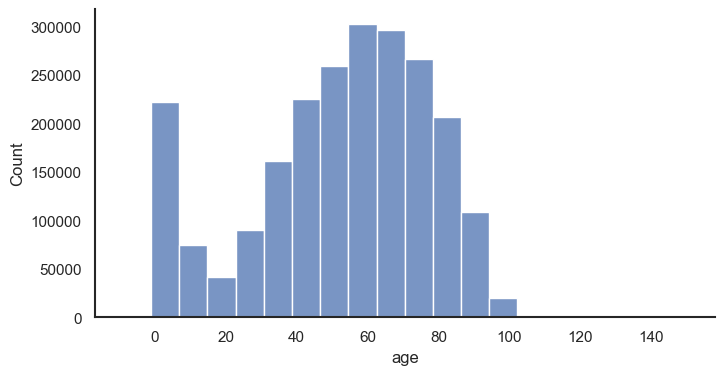

In [16]:
sns.histplot(data=df, x='age', bins=20);

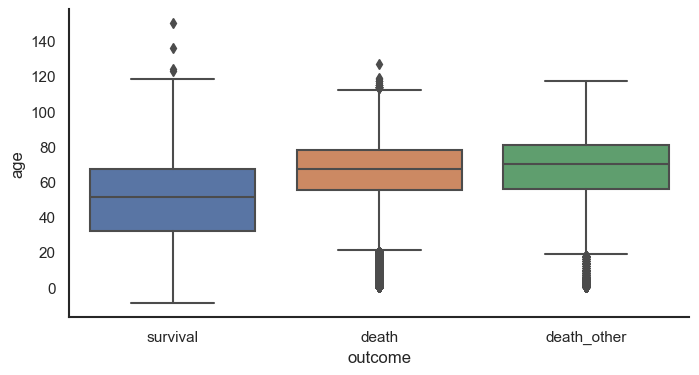

In [17]:
sns.boxplot(data=df, x='outcome', y='age');

In [18]:
df.groupby(['outcome'])['age'].mean()

outcome
death          65.774622
death_other    65.838602
survival       47.468695
Name: age, dtype: float64

### Sex

In [19]:
# Checking the percentage of missing values
df['CS_SEXO'].isna().sum()/df.shape[0]

0.0

In [20]:
df['CS_SEXO'].value_counts()

CS_SEXO
M    1218110
F    1057187
I        382
Name: count, dtype: int64

In [21]:
sex_dict = {'M': 'male', 
            'F': 'female'}
df['sex'] = df['CS_SEXO'].apply(sex_dict.get)
df['sex'] = pd.Categorical(df['sex'])
df['sex'].value_counts()

sex
male      1218110
female    1057187
Name: count, dtype: int64

In [22]:
df['sex'].value_counts(normalize=True, dropna=False)

sex
male      0.535273
female    0.464559
NaN       0.000168
Name: proportion, dtype: float64

In [23]:
df_missing.loc['sex', 'n'] = df['sex'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['sex']

n         382
%    0.000168
Name: sex, dtype: object

### Race

1 - white
 
2 - black
 
3 - asian
 
4 - mixed
 
5 - indigenous
 
9 - ignored

In [24]:
df['CS_RACA'].isna().sum()/df.shape[0]

0.0

In [25]:
df['CS_RACA'].value_counts()

CS_RACA
1    955371
4    808635
9    393466
2     93404
3     20490
5      4313
Name: count, dtype: int64

In [26]:
race_dict = {'1': 'white', '2': 'black',
             '3': 'asian', '4': 'mixed',
             '5': 'indigenous'}
df['race'] = df['CS_RACA'].apply(lambda x: race_dict.get(x))
df['race'] = pd.Categorical(df['race'])
df['race'].value_counts()

race
white         955371
mixed         808635
black          93404
asian          20490
indigenous      4313
Name: count, dtype: int64

In [27]:
df_missing.loc['race', 'n'] = df['race'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['race']

n    393466
%    0.1729
Name: race, dtype: object

### Education

1 - illiterate

2 - 5_grade

3 - 9_grade

4 - 12_grade

5 - not_applicable

9 - ignored

In [28]:
df['CS_ESCOL_N'].isna().sum()/df.shape[0]

0.3602182030066631

In [29]:
df['CS_ESCOL_N'].value_counts()

CS_ESCOL_N
9    657881
3    205804
1    202890
2    128940
5     95835
4     85262
0     79326
Name: count, dtype: int64

In [30]:
ed_dict = {'0': 'illiterate', 
           '1': '5_grade', 
           '2': '9_grade', 
           '3': '12_grade', 
           '4': 'higher_ed'}
df['education'] = df['CS_ESCOL_N'].apply(lambda x: ed_dict.get(x))
school_cat = ['illiterate', '5_grade', 
              '9_grade', '12_grade', 'higher_ed']
df['education'] = pd.Categorical(df['education'], categories=school_cat)
df['education'].value_counts().sort_index()

education
illiterate     79326
5_grade       202890
9_grade       128940
12_grade      205804
higher_ed      85262
Name: count, dtype: int64

In [31]:
df_missing.loc['education', 'n'] = df['education'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['education']

n     1573457
%    0.691423
Name: education, dtype: object

## 2.3 Vaccination Status

1 - vaccinated

2 - unvaccinated

9 - ignored

In [32]:
df['VACINA_COV'].isna().sum()/df.shape[0]

0.201826356001879

In [33]:
vaccination_dict = {'1': 'vaccinated', 
                    '2': 'unvaccinated'}
df['vaccination_status'] = df['VACINA_COV'].apply(lambda x: vaccination_dict.get(x))
df['vaccination_status'] = pd.Categorical(df['vaccination_status'], categories=['vaccinated', 'unvaccinated'])
df['vaccination_status'].value_counts()

vaccination_status
unvaccinated    794844
vaccinated      722594
Name: count, dtype: int64

In [34]:
df_missing.loc['vaccination_status', 'n'] = df['vaccination_status'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['vaccination_status']

n      758241
%    0.333193
Name: vaccination_status, dtype: object

### Presence of vaccination dates

In [35]:
df['first_dose_date'] = df['DOSE_1_COV'].apply(lambda x: 0 if pd.isna(x) else 1)
df['first_dose_date'].value_counts()

first_dose_date
0    1619167
1     656512
Name: count, dtype: int64

In [36]:
df.groupby(['vaccination_status'])['first_dose_date'].value_counts()

vaccination_status  first_dose_date
vaccinated          1                  654908
                    0                   67686
unvaccinated        0                  794135
                    1                     709
Name: count, dtype: int64

- There are vaccinated patients with no date of first_dose 
- There are unvaccinated patients with date of first_dose 

In [37]:
df['second_dose_date'] = df['DOSE_2_COV'].apply(lambda x: 0 if pd.isna(x) else 1)
df['second_dose_date'].value_counts()

second_dose_date
0    1757237
1     518442
Name: count, dtype: int64

In [38]:
df.groupby(['first_dose_date'])['second_dose_date'].value_counts()

first_dose_date  second_dose_date
0                0                   1606690
                 1                     12477
1                1                    505965
                 0                    150547
Name: count, dtype: int64

- There are patients with date of second_dose without date of first_dose

In [39]:
df['booster_date'] = df['DOSE_REF'].apply(lambda x: 0 if pd.isna(x) else 1)
df['booster_date'].value_counts()

booster_date
0    2101459
1     174220
Name: count, dtype: int64

In [40]:
df.groupby(['second_dose_date'])['booster_date'].value_counts()

second_dose_date  booster_date
0                 0               1749560
                  1                  7677
1                 0                351899
                  1                166543
Name: count, dtype: int64

- There are patients with date of booster without date of second_dose

Inconsistencies found: 
- Vaccinated with empty first_dose_date 
- Unvaccinated with first_dose_date 
- first_dose_date == 0 and second_dose_date == 1
- second_dose_date == 0 and booster_date == 1

### Vaccine Manufacturers

#### First dose

In [41]:
df['FAB_COV_1'].nunique()

7371

In [42]:
df['FAB_COV_1'].value_counts().head(20)

FAB_COV_1
86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC        182170
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD    141846
87 - COVID-19 PFIZER - COMIRNATY                   58553
CORONAVAC                                          48402
BUTANTAN                                           32105
ASTRAZENECA                                        27653
FIOCRUZ                                            14245
PFIZER                                             12636
ASTRAZENICA                                        11669
89 - COVID-19 ASTRAZENECA - CHADOX1-S               6583
99 - COVID-19 PEDIATRICA - PFIZER COMIRNATY         6067
FUNDACAO BUTANTAN                                   5772
SINOVAC                                             5632
88 - COVID-19 JANSSEN - AD26.COV2.S                 5320
OXFORD                                              5097
86 - COVID-19-CORONAVAC-SINOVAC/BUTANTAN            5043
SINOVAC/BUTANTAN                                    4934
ASTRAZENECA/OXFORD/FI

#### Second dose

In [43]:
df['FAB_COV_2'].nunique()

450

In [44]:
df['FAB_COV_2'].value_counts().head(20)

FAB_COV_2
86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC        134677
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD     90824
87 - COVID-19 PFIZER - COMIRNATY                   32915
89 - COVID-19 ASTRAZENECA - CHADOX1-S               6705
99 - COVID-19 PEDIATRICA - PFIZER COMIRNATY         3215
CORONAVAC                                           2572
BUTANTAN                                            1240
PFIZER                                              1217
ASTRAZENECA                                         1129
FIOCRUZ                                              596
ASTRAZENECA/OXFORD/FIOCRUZ                           593
ASTRAZENICA                                          378
INSTITUTO BUTANTAN                                   326
98 - COVID-19 SINOVAC - CORONAVAC                    307
SINOVAC/BUTANTAN                                     268
SINOVAC                                              228
FUNDACAO OSWALDO CRUZ                                143
ASTRAZENECA/FIOCRUZ  

#### Booster

In [45]:
df['FAB_COVREF'].nunique()

239

In [46]:
df['FAB_COVREF'].value_counts().head(20)

FAB_COVREF
87 - COVID-19 PFIZER - COMIRNATY                  127147
88 - COVID-19 JANSSEN - AD26.COV2.S                14367
86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC         13200
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD     12790
PFIZER                                              3980
CORONAVAC                                            478
JANSSEN                                              208
PFIZER MANUFACTURING BELGIUM NV - BELGICA            181
VACINA COVID-19-RNAM, PFIZER (COMIRNATY)             114
ASTRAZENECA                                           94
89 - COVID-19 ASTRAZENECA - CHADOX1-S                 77
98 - COVID-19 SINOVAC - CORONAVAC                     57
SINOVAC                                               54
FIOCRUZ                                               50
VACINA COVID-19 PFIZER                                49
BUTANTAN                                              48
ASTRAZENICA                                           39
SINOVAC/BUTANTAN    

## 2.4 Comorbidities

1 - yes

2 - no

9 - ignored

### Obesity 

In [47]:
df['OBESIDADE'].isna().sum() / df.shape[0]

0.6473878785188948

In [48]:
df['OBESIDADE'].value_counts()

OBESIDADE
2    630146
1    153164
9     19122
Name: count, dtype: int64

In [49]:
obesity_dict = {'1': 'obesity', 
                '2': 'no_obesity'}
df['obesity'] = df['OBESIDADE'].apply(obesity_dict.get)

obesity_cat = ['obesity', 'no_obesity'] 
df['obesity'] = pd.Categorical(df['obesity'], categories=obesity_cat)
df['obesity'].value_counts()

obesity
no_obesity    630146
obesity       153164
Name: count, dtype: int64

In [50]:
df_missing.loc['obesity', 'n'] = df['obesity'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['obesity']

n     1492369
%    0.655791
Name: obesity, dtype: object

### BMI

In [51]:
df['bmi'] = df['OBES_IMC'].str.replace(',', '.')
df['bmi'] = pd.to_numeric(df['bmi'])
df['bmi'].describe()

count    23779.000000
mean        28.648634
std         26.010835
min          0.000000
25%         27.700000
50%         32.000000
75%         37.900000
max       3000.000000
Name: bmi, dtype: float64

In [52]:
df.groupby(['OBESIDADE'])['bmi'].mean()

OBESIDADE
1    28.648634
2          NaN
9          NaN
Name: bmi, dtype: float64

- BMI is only filled out for patients with obesity

In [53]:
df.groupby(['outcome'])['bmi'].mean()

outcome
death          30.392107
death_other    28.772038
survival       27.835136
Name: bmi, dtype: float64

In [54]:
df['bmi'].describe()

count    23779.000000
mean        28.648634
std         26.010835
min          0.000000
25%         27.700000
50%         32.000000
75%         37.900000
max       3000.000000
Name: bmi, dtype: float64

BMI is not a reliable variable because: 
- It's only filled out in patients with obesity
- Many values are close to 0, which does not match the obesity criteria of BMI >=30
- May include calculation errors

### Diabetes

In [55]:
df['DIABETES'].isna().sum()/df.shape[0]

0.5959873954103369

In [56]:
df['DIABETES'].value_counts()

DIABETES
2    496069
1    411963
9     11371
Name: count, dtype: int64

In [57]:
diabetes_dict = {'1': 'diabetes', 
                 '2': 'no_diabetes'}
df['diabetes'] = df['DIABETES'].apply(diabetes_dict.get)

diabetes_cat = ['diabetes', 'no_diabetes'] 
df['diabetes'] = pd.Categorical(df['diabetes'], categories=diabetes_cat)
df['diabetes'].value_counts()

diabetes
no_diabetes    496069
diabetes       411963
Name: count, dtype: int64

In [58]:
df_missing.loc['diabetes', 'n'] = df['diabetes'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['diabetes']

n     1367647
%    0.600984
Name: diabetes, dtype: object

### Heart disease

In [59]:
df['CARDIOPATI'].isna().sum()/df.shape[0]

0.5636985708441304

In [60]:
df['CARDIOPATI'].value_counts()

CARDIOPATI
1    610508
2    372594
9      9780
Name: count, dtype: int64

In [61]:
heart_disease_dict = {'1': 'heart_disease', 
                      '2': 'no_heart_disease'}
df['heart_disease'] = df['CARDIOPATI'].apply(heart_disease_dict.get)

heart_disease_cat = ['heart_disease', 'no_heart_disease'] 
df['heart_disease'] = pd.Categorical(df['heart_disease'], categories=heart_disease_cat)
df['heart_disease'].value_counts()

heart_disease
heart_disease       610508
no_heart_disease    372594
Name: count, dtype: int64

In [62]:
df_missing.loc['heart_disease', 'n'] = df['heart_disease'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['heart_disease']

n     1292577
%    0.567996
Name: heart_disease, dtype: object

### Lung disease

In [63]:
df['PNEUMOPATI'].isna().sum()/df.shape[0]

0.6563311433642443

In [64]:
df['PNEUMOPATI'].value_counts()

PNEUMOPATI
2    681290
1     84706
9     16084
Name: count, dtype: int64

In [65]:
lung_disease_dict = {'1': 'lung_disease', 
                      '2': 'no_lung_disease'}
df['lung_disease'] = df['PNEUMOPATI'].apply(lung_disease_dict.get)

lung_disease_cat = ['lung_disease', 'no_lung_disease'] 
df['lung_disease'] = pd.Categorical(df['lung_disease'], categories=lung_disease_cat)
df['lung_disease'].value_counts()

lung_disease
no_lung_disease    681290
lung_disease        84706
Name: count, dtype: int64

In [66]:
df_missing.loc['lung_disease', 'n'] = df['lung_disease'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['lung_disease']

n     1509683
%    0.663399
Name: lung_disease, dtype: object

### Kidney disease

In [67]:
df['RENAL'].isna().sum()/df.shape[0]

0.6597024448527231

In [68]:
df['RENAL'].value_counts()

RENAL
2    691192
1     67551
9     15665
Name: count, dtype: int64

In [69]:
kidney_disease_dict = {'1': 'kidney_disease', 
                       '2': 'no_kidney_disease'}
df['kidney_disease'] = df['RENAL'].apply(kidney_disease_dict.get)

kidney_disease_cat = ['kidney_disease', 'no_kidney_disease'] 
df['kidney_disease'] = pd.Categorical(df['kidney_disease'], categories=kidney_disease_cat)
df['kidney_disease'].value_counts()

kidney_disease
no_kidney_disease    691192
kidney_disease        67551
Name: count, dtype: int64

In [70]:
df_missing.loc['kidney_disease', 'n'] = df['kidney_disease'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['kidney_disease']

n     1516936
%    0.666586
Name: kidney_disease, dtype: object

### Liver disease

In [71]:
df['HEPATICA'].isna().sum()/df.shape[0]

0.6672786451867773

In [72]:
df['HEPATICA'].value_counts()

HEPATICA
2    723776
9     16727
1     16664
Name: count, dtype: int64

In [73]:
liver_disease_dict = {'1': 'liver_disease', 
                      '2': 'no_liver_disease'}
df['liver_disease'] = df['HEPATICA'].apply(liver_disease_dict.get)

liver_disease_cat = ['liver_disease', 'no_liver_disease'] 
df['liver_disease'] = pd.Categorical(df['liver_disease'], categories=liver_disease_cat)
df['liver_disease'].value_counts()

liver_disease
no_liver_disease    723776
liver_disease        16664
Name: count, dtype: int64

In [74]:
df_missing.loc['liver_disease', 'n'] = df['liver_disease'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['liver_disease']

n     1535239
%    0.674629
Name: liver_disease, dtype: object

### Blood disease

In [75]:
df['HEMATOLOGI'].isna().sum()/df.shape[0]

0.6660214379971868

In [76]:
df['HEMATOLOGI'].value_counts()

HEMATOLOGI
2    727522
9     16780
1     15726
Name: count, dtype: int64

In [77]:
blood_disease_dict = {'1': 'blood_disease', 
                      '2': 'no_blood_disease'}
df['blood_disease'] = df['HEMATOLOGI'].apply(blood_disease_dict.get)

blood_disease_cat = ['blood_disease', 'no_blood_disease'] 
df['blood_disease'] = pd.Categorical(df['blood_disease'], categories=blood_disease_cat)
df['blood_disease'].value_counts()

blood_disease
no_blood_disease    727522
blood_disease        15726
Name: count, dtype: int64

In [78]:
df_missing.loc['blood_disease', 'n'] = df['blood_disease'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['blood_disease']

n     1532431
%    0.673395
Name: blood_disease, dtype: object

### Immunodeficiency

In [79]:
df['IMUNODEPRE'].isna().sum()/df.shape[0]

0.6618701495246034

In [80]:
df['IMUNODEPRE'].value_counts()

IMUNODEPRE
2    698616
1     54286
9     16573
Name: count, dtype: int64

In [81]:
immuno_dict = {'1': 'immunodeficiency', 
               '2': 'no_immunodeficiency'}
df['immunodeficiency'] = df['IMUNODEPRE'].apply(immuno_dict.get)

immuno_cat = ['immunodeficiency', 'no_immunodeficiency'] 
df['immunodeficiency'] = pd.Categorical(df['immunodeficiency'], categories=immuno_cat)
df['immunodeficiency'].value_counts()

immunodeficiency
no_immunodeficiency    698616
immunodeficiency        54286
Name: count, dtype: int64

In [82]:
df_missing.loc['immunodeficiency', 'n'] = df['immunodeficiency'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['immunodeficiency']

n     1522777
%    0.669153
Name: immunodeficiency, dtype: object

### Asthma

In [83]:
df['ASMA'].isna().sum()/df.shape[0]

0.6577175427641596

In [84]:
df['ASMA'].value_counts()

ASMA
2    687121
1     76623
9     15181
Name: count, dtype: int64

In [85]:
asthma_dict = {'1': 'asthma', 
               '2': 'no_asthma'}
df['asthma'] = df['ASMA'].apply(asthma_dict.get)

asthma_cat = ['asthma', 'no_asthma'] 
df['asthma'] = pd.Categorical(df['asthma'], categories=asthma_cat)
df['asthma'].value_counts()

asthma
no_asthma    687121
asthma        76623
Name: count, dtype: int64

In [86]:
df_missing.loc['asthma', 'n'] = df['asthma'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['asthma']

n     1511935
%    0.664389
Name: asthma, dtype: object

### Pregnancy

In [87]:
df['PUERPERA'].isna().sum()/df.shape[0]

0.6666656413316641

In [88]:
df['PUERPERA'].value_counts()

PUERPERA
2    735200
9     15762
1      7600
Name: count, dtype: int64

In [89]:
pregnancy_dict = {'1': 'pregnancy', 
                  '2': 'no_pregnancy'}
df['pregnancy'] = df['PUERPERA'].apply(pregnancy_dict.get)

pregnancy_cat = ['pregnancy', 'no_pregnancy'] 
df['pregnancy'] = pd.Categorical(df['pregnancy'], categories=pregnancy_cat)
df['pregnancy'].value_counts()

pregnancy
no_pregnancy    735200
pregnancy         7600
Name: count, dtype: int64

In [90]:
df_missing.loc['pregnancy', 'n'] = df['pregnancy'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['pregnancy']

n     1532879
%    0.673592
Name: pregnancy, dtype: object

### Neurological disease

In [91]:
df['NEUROLOGIC'].isna().sum()/df.shape[0]

0.6559352175768199

In [92]:
df['NEUROLOGIC'].value_counts()

NEUROLOGIC
2    678852
1     88300
9     15829
Name: count, dtype: int64

In [93]:
neuro_dict = {'1': 'neuro_disease', 
               '2': 'no_neuro_disease'}
df['neuro_disease'] = df['NEUROLOGIC'].apply(neuro_dict.get)

neuro_disease_cat = ['neuro_disease', 'no_neuro_disease'] 
df['neuro_disease'] = pd.Categorical(df['neuro_disease'], categories=neuro_disease_cat)
df['neuro_disease'].value_counts()

neuro_disease
no_neuro_disease    678852
neuro_disease        88300
Name: count, dtype: int64

In [94]:
df_missing.loc['neuro_disease', 'n'] = df['neuro_disease'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['neuro_disease']

n     1508527
%    0.662891
Name: neuro_disease, dtype: object

## 2.5 Signs and Symptoms:

1 - yes

2 - no

9 - ignored

### Fever

In [95]:
df['FEBRE'].isna().sum()/df.shape[0]

0.18509816191123615

In [96]:
df['FEBRE'].value_counts()

FEBRE
1    1167742
2     660085
9      26628
Name: count, dtype: int64

In [97]:
fever_dict = {'1': 'fever', 
              '2': 'no_fever'}
df['fever'] = df['FEBRE'].apply(fever_dict.get)

fever_cat = ['fever', 'no_fever'] 
df['fever'] = pd.Categorical(df['fever'], categories=fever_cat)
df['fever'].value_counts()

fever
fever       1167742
no_fever     660085
Name: count, dtype: int64

In [98]:
df_missing.loc['fever', 'n'] = df['fever'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['fever']

n      447852
%    0.196799
Name: fever, dtype: object

### Cough

In [99]:
df['TOSSE'].isna().sum()/df.shape[0]

0.13763320749543323

In [100]:
df['TOSSE'].value_counts()

TOSSE
1    1526466
2     414918
9      21086
Name: count, dtype: int64

In [101]:
cough_dict = {'1': 'cough', 
              '2': 'no_cough'}
df['cough'] = df['TOSSE'].apply(cough_dict.get)

cough_cat = ['cough', 'no_cough'] 
df['cough'] = pd.Categorical(df['cough'], categories=cough_cat)
df['cough'].value_counts()

cough
cough       1526466
no_cough     414918
Name: count, dtype: int64

In [102]:
df_missing.loc['cough', 'n'] = df['cough'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['cough']

n      334295
%    0.146899
Name: cough, dtype: object

### Sore Throat

In [103]:
df['GARGANTA'].isna().sum()/df.shape[0]

0.3148014284967256

In [104]:
df['GARGANTA'].value_counts()

GARGANTA
2    1163502
1     351398
9      44392
Name: count, dtype: int64

In [105]:
sore_throat_dict = {'1': 'sore_throat', 
               '2': 'no_sore_throat'}
df['sore_throat'] = df['GARGANTA'].apply(sore_throat_dict.get)

sore_throat_cat = ['sore_throat', 'no_sore_throat'] 
df['sore_throat'] = pd.Categorical(df['sore_throat'], categories=sore_throat_cat)
df['sore_throat'].value_counts()

sore_throat
no_sore_throat    1163502
sore_throat        351398
Name: count, dtype: int64

In [106]:
df_missing.loc['sore_throat', 'n'] = df['sore_throat'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['sore_throat']

n      760779
%    0.334309
Name: sore_throat, dtype: object

### Dyspnea

In [107]:
df['DISPNEIA'].isna().sum()/df.shape[0]

0.14246868736759447

In [108]:
df['DISPNEIA'].value_counts()

DISPNEIA
1    1516422
2     415691
9      19353
Name: count, dtype: int64

In [109]:
dyspnea_dict = {'1': 'dyspnea', 
               '2': 'no_dyspnea'}
df['dyspnea'] = df['DISPNEIA'].apply(dyspnea_dict.get)

dyspnea_cat = ['dyspnea', 'no_dyspnea'] 
df['dyspnea'] = pd.Categorical(df['dyspnea'], categories=dyspnea_cat)
df['dyspnea'].value_counts()

dyspnea
dyspnea       1516422
no_dyspnea     415691
Name: count, dtype: int64

In [110]:
df_missing.loc['dyspnea', 'n'] = df['dyspnea'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['dyspnea']

n      343566
%    0.150973
Name: dyspnea, dtype: object

### Respiratory Discomfort

In [111]:
df['DESC_RESP'].isna().sum()/df.shape[0]

0.20982748445628754

In [112]:
df['DESC_RESP'].value_counts()

DESC_RESP
1    1205283
2     568052
9      24844
Name: count, dtype: int64

In [113]:
resp_discomfort_dict = {'1': 'resp_discomfort', 
               '2': 'no_resp_discomfort'}
df['resp_discomfort'] = df['DESC_RESP'].apply(resp_discomfort_dict.get)

resp_discomfort_cat = ['resp_discomfort', 'no_resp_discomfort'] 
df['resp_discomfort'] = pd.Categorical(df['resp_discomfort'], categories=resp_discomfort_cat)
df['resp_discomfort'].value_counts()

resp_discomfort
resp_discomfort       1205283
no_resp_discomfort     568052
Name: count, dtype: int64

In [114]:
df_missing.loc['resp_discomfort', 'n'] = df['resp_discomfort'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['resp_discomfort']

n      502344
%    0.220745
Name: resp_discomfort, dtype: object

### Oxygen Saturation

In [115]:
df['SATURACAO'].isna().sum()/df.shape[0]

0.18072012792665398

In [116]:
df['SATURACAO'].value_counts()

SATURACAO
1    1362204
2     476825
9      25389
Name: count, dtype: int64

In [117]:
oxygen_saturation_dict = {'1': 'oxygen_saturation', 
              '2': 'no_oxygen_saturation'}
df['oxygen_saturation'] = df['SATURACAO'].apply(oxygen_saturation_dict.get)

oxygen_saturation_cat = ['oxygen_saturation', 'no_oxygen_saturation'] 
df['oxygen_saturation'] = pd.Categorical(df['oxygen_saturation'], categories=oxygen_saturation_cat)
df['oxygen_saturation'].value_counts()

oxygen_saturation
oxygen_saturation       1362204
no_oxygen_saturation     476825
Name: count, dtype: int64

In [118]:
df_missing.loc['oxygen_saturation', 'n'] = df['oxygen_saturation'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['oxygen_saturation']

n      436650
%    0.191877
Name: oxygen_saturation, dtype: object

### Diarrhea

In [119]:
df['DIARREIA'].isna().sum()/df.shape[0]

0.33003600244146913

In [120]:
df['DIARREIA'].value_counts()

DIARREIA
2    1240043
1     245503
9      39077
Name: count, dtype: int64

In [121]:
diarrhea_dict = {'1': 'diarrhea', 
                 '2': 'no_diarrhea'}
df['diarrhea'] = df['DIARREIA'].apply(diarrhea_dict.get)

diarrhea_cat = ['diarrhea', 'no_diarrhea'] 
df['diarrhea'] = pd.Categorical(df['diarrhea'], categories=diarrhea_cat)
df['diarrhea'].value_counts()

diarrhea
no_diarrhea    1240043
diarrhea        245503
Name: count, dtype: int64

In [122]:
df_missing.loc['diarrhea', 'n'] = df['diarrhea'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['diarrhea']

n      790133
%    0.347208
Name: diarrhea, dtype: object

### Vomiting

In [123]:
df['VOMITO'].isna().sum()/df.shape[0]

0.3364670500540718

In [124]:
df['VOMITO'].value_counts()

VOMITO
2    1269114
1     200888
9      39986
Name: count, dtype: int64

In [125]:
vomiting_dict = {'1': 'vomiting', 
                 '2': 'no_vomiting'}
df['vomiting'] = df['VOMITO'].apply(vomiting_dict.get)

vomiting_cat = ['vomiting', 'no_vomiting'] 
df['vomiting'] = pd.Categorical(df['vomiting'], categories=vomiting_cat)
df['vomiting'].value_counts()

vomiting
no_vomiting    1269114
vomiting        200888
Name: count, dtype: int64

In [126]:
df_missing.loc['vomiting', 'n'] = df['vomiting'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['vomiting']

n      805677
%    0.354038
Name: vomiting, dtype: object

### Abdominal Pain

In [127]:
df['DOR_ABD'].isna().sum()/df.shape[0]

0.3496138954571361

In [128]:
df['DOR_ABD'].value_counts()

DOR_ABD
2    1295625
1     135839
9      48606
Name: count, dtype: int64

In [129]:
abdominal_pain_dict = {'1': 'abdominal_pain', 
                 '2': 'no_abdominal_pain'}
df['abdominal_pain'] = df['DOR_ABD'].apply(abdominal_pain_dict.get)

abd_pain_cat = ['abdominal_pain', 'no_abdominal_pain'] 
df['abdominal_pain'] = pd.Categorical(df['abdominal_pain'], categories=abd_pain_cat)
df['abdominal_pain'].value_counts()

abdominal_pain
no_abdominal_pain    1295625
abdominal_pain        135839
Name: count, dtype: int64

In [130]:
df_missing.loc['abdominal_pain', 'n'] = df['abdominal_pain'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['abdominal_pain']

n      844215
%    0.370973
Name: abdominal_pain, dtype: object

### Fatigue

In [131]:
df['FADIGA'].isna().sum()/df.shape[0]

0.3116182027430055

In [132]:
df['FADIGA'].value_counts()

FADIGA
2    1008702
1     514491
9      43343
Name: count, dtype: int64

In [133]:
fatigue_dict = {'1': 'fatigue', 
                 '2': 'no_fatigue'}
df['fatigue'] = df['FADIGA'].apply(fatigue_dict.get)

fatigue_cat = ['fatigue', 'no_fatigue'] 
df['fatigue'] = pd.Categorical(df['fatigue'], categories=fatigue_cat)
df['fatigue'].value_counts()

fatigue
no_fatigue    1008702
fatigue        514491
Name: count, dtype: int64

In [134]:
df_missing.loc['fatigue', 'n'] = df['fatigue'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['fatigue']

n      752486
%    0.330664
Name: fatigue, dtype: object

### Loss of Smell

In [135]:
df['PERD_OLFT'].isna().sum()/df.shape[0]

0.34589939969565126

In [136]:
df['PERD_OLFT'].value_counts()

PERD_OLFT
2    1282667
1     147497
9      58359
Name: count, dtype: int64

In [137]:
loss_smell_dict = {'1': 'loss_smell', 
                 '2': 'no_loss_smell'}
df['loss_smell'] = df['PERD_OLFT'].apply(loss_smell_dict.get)

loss_smell_cat = ['loss_smell', 'no_loss_smell'] 
df['loss_smell'] = pd.Categorical(df['loss_smell'], categories=loss_smell_cat)
df['loss_smell'].value_counts()

loss_smell
no_loss_smell    1282667
loss_smell        147497
Name: count, dtype: int64

In [138]:
df_missing.loc['loss_smell', 'n'] = df['loss_smell'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['loss_smell']

n      845515
%    0.371544
Name: loss_smell, dtype: object

### Loss of Taste

In [139]:
df['PERD_PALA'].isna().sum()/df.shape[0]

0.3463296009674475

In [140]:
df['PERD_PALA'].value_counts()

PERD_PALA
2    1277907
1     150230
9      59407
Name: count, dtype: int64

In [141]:
loss_taste_dict = {'1': 'loss_taste', 
                   '2': 'no_loss_taste'}
df['loss_taste'] = df['PERD_PALA'].apply(loss_taste_dict.get)

loss_taste_cat = ['loss_taste', 'no_loss_taste']
df['loss_taste'] = pd.Categorical(df['loss_taste'], categories=loss_taste_cat)
df['loss_taste'].value_counts()

loss_taste
no_loss_taste    1277907
loss_taste        150230
Name: count, dtype: int64

In [142]:
df_missing.loc['loss_taste', 'n'] = df['loss_taste'].isna().sum()
df_missing['%'] = df_missing['n'] / df.shape[0]
df_missing.loc['loss_taste']

n      847542
%    0.372435
Name: loss_taste, dtype: object

### Other Symptoms

In [143]:
df['OUTRO_DES'].isna().sum()/df.shape[0]

0.6991508907890788

In [144]:
df['OUTRO_DES'].nunique()

133040

In [145]:
df['OUTRO_DES'].value_counts().head(20)

OUTRO_DES
CEFALEIA              57754
CORIZA                54717
MIALGIA               50582
ASTENIA               18332
INAPETENCIA           13935
DOR TORACICA          13265
FRAQUEZA               7908
CEFALEIA, MIALGIA      7053
CANSACO                6884
MAL ESTAR              5500
MIALGIA, CEFALEIA      5277
PROSTRACAO             4653
ASSINTOMATICO          4388
CONGESTAO NASAL        4357
NAUSEAS                4028
DOR NO CORPO           3956
DOR DE CABECA          3403
CEFALEIA E MIALGIA     3019
ADINAMIA               2716
CONFUSAO MENTAL        2694
Name: count, dtype: int64

### Table with the counts of missing values for all variables of interest

In [146]:
greater_40 = 0
for perc in df_missing['%'].values:
    if perc >= 0.4:
        greater_40 += 1
    
print(f'There are {greater_40} variables with >=40% of missing data')

df_missing.to_excel('Missing_data_counts_initial_dataset.xlsx')
df_missing

There are 12 variables with >=40% of missing data


,n,%
Variable,,
outcome,299911,0.13179
age,0,0.0
sex,382,0.000168
race,393466,0.1729
education,1573457,0.691423
vaccination_status,758241,0.333193
obesity,1492369,0.655791
diabetes,1367647,0.600984
heart_disease,1292577,0.567996


In [147]:
df.shape[0]

2275679

## 2.6 Obtaining the final dataset

### Confirmed hospitalizations: 
1 - yes 

2 - no

9 - ignored

In [148]:
# Including only cases that were confirmed hospitalizations
df = df[df['HOSPITAL'] == '1'].copy() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2162503 entries, 0 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), float64(1), int64(4), object(167)
memory usage: 2.8+ GB


### Confirmed COVID-19 cases: 
1 - Severe accute respiratory syndrome caused by influenza

2 - Severe accute respiratory syndrome caused by other respiratory virus

3 - Severe accute respiratory syndrome caused by other agent, specify:

4 - Severe accute respiratory syndrome not specified

5 - Severe accute respiratory syndrome caused by SARS-CoV2

In [149]:
# Including only confirmed COVID-19 cases
df = df[df['CLASSI_FIN'] == '5'].copy() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384218 entries, 0 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), float64(1), int64(4), object(167)
memory usage: 1.8+ GB


In [150]:
# Selecting data starting on July 1, 2021 to balance the number of vaccinated people
start_date = datetime(year=2021, month=6, day=30)
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], format='%d/%m/%Y')
df = df[df['DT_SIN_PRI'] > start_date].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410959 entries, 8354 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), datetime64[ns](1), float64(1), int64(4), object(166)
memory usage: 553.0+ MB


In [151]:
df['DT_SIN_PRI'].describe()

count                           410959
mean     2021-12-30 16:10:55.598247424
min                2021-07-01 00:00:00
25%                2021-08-16 00:00:00
50%                2022-01-09 00:00:00
75%                2022-03-04 00:00:00
max                2023-01-01 00:00:00
Name: DT_SIN_PRI, dtype: object

In [152]:
# Excluding missing values and death_other for the target variable
df = df[(pd.notna(df['outcome'])) & 
        (df['outcome'] != 'death_other')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372460 entries, 8354 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), datetime64[ns](1), float64(1), int64(4), object(166)
memory usage: 501.2+ MB


In [153]:
# Filtering age
df = df[((df['age'] >= 18) & # including only adults
         (df['age'] < np.percentile(df['age'], 99.9)))].copy() # excluding the 99.9% percentile
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349400 entries, 8354 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), datetime64[ns](1), float64(1), int64(4), object(166)
memory usage: 470.2+ MB


In [154]:
# Removing inconsistencies with doses
df = df[~((df['vaccination_status'] == 'vaccinated') & (df['first_dose_date'] == 0)) &
        ~((df['vaccination_status'] == 'unvaccinated') & (df['first_dose_date'] == 1)) &
        ~((df['first_dose_date'] == 0) & (df['second_dose_date'] == 1)) &
        ~((df['second_dose_date'] == 0) & (df['booster_date'] == 1))].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325789 entries, 8354 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), datetime64[ns](1), float64(1), int64(4), object(166)
memory usage: 438.4+ MB


### Days between vaccination and hospitalization

In [155]:
# Inconsistent dates 
date_filter_1 = df['DT_INTERNA'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_2 = df['DT_INTERNA'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022
date_filter_3 = df['DOSE_1_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_4 = df['DOSE_1_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022
date_filter_5 = df['DOSE_2_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_6 = df['DOSE_2_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022
date_filter_7 = df['DOSE_REF'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_8 = df['DOSE_REF'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022

In [156]:
# Hospitalizations before 2021
df[date_filter_1]['DT_INTERNA'].values

array(['07/12/2020', '30/07/2020', '14/09/2020', '19/11/2019'],
      dtype=object)

In [157]:
# Hospitalizations after 2022
df[date_filter_2]['DT_INTERNA'].unique()

array(['02/08/7202', '05/08/5022', '19/12/2202', '30/01/3022'],
      dtype=object)

In [158]:
# First dose before 2021
df[date_filter_3]['DOSE_1_COV'].unique()

array(['15/08/2020', '15/05/2020', '20/04/2019', '23/03/2020',
       '21/01/2020', '02/07/2020', '20/04/1974', '29/01/2020',
       '25/05/0021', '21/03/2020', '22/03/1921', '21/05/2020',
       '05/02/2020', '27/12/2020', '25/02/2020', '05/03/2020',
       '20/05/2020', '22/03/2020', '01/12/2020', '03/12/2020',
       '24/07/2019', '12/02/2020', '11/08/2012', '01/03/0202',
       '21/09/2020', '26/03/2012', '17/06/2020', '23/09/2020',
       '27/03/2016', '10/05/2002', '12/02/0202', '29/06/2020',
       '05/05/2019', '20/12/2020', '05/04/2020', '05/10/2020',
       '12/12/2020', '04/06/2020', '19/11/2020', '04/03/2020',
       '01/03/2020', '14/08/2020', '26/03/2020', '10/05/2020',
       '12/07/2020', '20/03/2020', '21/07/2020'], dtype=object)

In [159]:
# First dose after 2022
df[date_filter_4]['DOSE_1_COV'].unique()

array(['21/06/2201', '26/01/2201', '28/02/8202', '10/02/2201',
       '22/04/2025', '23/05/8202', '02/04/7202', '21/01/2202',
       '23/03/3021', '19/05/2921', '31/03/2202', '24/06/3202',
       '15/02/2202', '09/02/2921', '27/06/3021', '26/10/3121',
       '03/03/2921', '05/03/2102', '02/06/3202', '01/03/2032',
       '23/04/2027', '16/02/2202'], dtype=object)

In [160]:
# Second dose before 2021
df[date_filter_5]['DOSE_2_COV'].unique()

array(['15/06/2020', '08/04/0202', '17/02/2020', '16/05/2020',
       '02/08/2011', '29/03/1202', '31/03/2020', '24/03/2020',
       '06/04/0202', '02/06/2003', '14/05/2020', '17/05/2020',
       '20/08/2020', '01/04/2020', '26/04/2020', '05/08/1899',
       '11/02/0201', '15/10/2020', '02/03/1899', '23/10/2020',
       '22/04/0202', '20/10/2000', '27/04/2020', '08/04/2002',
       '19/10/2020', '27/08/2020', '17/12/2020', '16/04/2020',
       '30/11/1954', '19/03/2020', '12/03/2020', '26/03/1921',
       '29/03/1921', '02/06/0520', '19/06/2020', '03/12/2011',
       '17/04/2020', '15/04/2011'], dtype=object)

In [161]:
# Second dose after 2022
df[date_filter_6]['DOSE_2_COV'].unique()

array(['27/04/7202', '22/03/2121', '29/04/2201', '30/05/3021',
       '15/03/2202', '25/06/3021', '16/08/2024', '18/02/2202',
       '20/05/2025', '25/04/2201', '24/04/2024', '24/04/4202',
       '21/04/3202', '05/03/2025', '31/03/2102', '08/04/2024',
       '27/04/2121', '23/04/2024', '25/07/5021', '16/06/9202',
       '14/01/4202', '23/10/4202', '24/05/5202', '27/05/5202'],
      dtype=object)

In [162]:
# Booster dose before 2021
df[date_filter_7]['DOSE_REF'].unique()

array([], dtype=object)

In [163]:
# Booster after after 2022
df[date_filter_8]['DOSE_REF'].unique()

array([], dtype=object)

In [164]:
# Removing inconsistencies with dose dates
df = df[~((date_filter_1) | 
          (date_filter_2) | 
          (date_filter_3) | 
          (date_filter_4) | 
          (date_filter_5) |
          (date_filter_6) |
          (date_filter_7) |
          (date_filter_8))].copy()

In [165]:
df['hosp_date'] = pd.to_datetime(df['DT_INTERNA'], format='%d/%m/%Y')
df['hosp_date'].describe()

count                           320919
mean     2021-12-26 20:57:09.814999808
min                2021-01-02 00:00:00
25%                2021-08-19 00:00:00
50%                2022-01-09 00:00:00
75%                2022-02-21 00:00:00
max                2022-12-30 00:00:00
Name: hosp_date, dtype: object

In [166]:
df['first_dose_date_value'] = pd.to_datetime(df['DOSE_1_COV'], format='%d/%m/%Y')
df['first_dose_date_value'].describe()

count                           210615
mean     2021-04-20 15:25:26.711772416
min                2021-01-01 00:00:00
25%                2021-03-05 00:00:00
50%                2021-03-30 00:00:00
75%                2021-05-27 00:00:00
max                2022-12-10 00:00:00
Name: first_dose_date_value, dtype: object

In [167]:
df['second_dose_date_value'] = pd.to_datetime(df['DOSE_2_COV'], format='%d/%m/%Y')
df['second_dose_date_value'].describe()

count                           178718
mean     2021-05-31 17:56:49.281661440
min                2021-01-04 00:00:00
25%                2021-04-08 00:00:00
50%                2021-05-04 00:00:00
75%                2021-07-28 00:00:00
max                2022-12-14 00:00:00
Name: second_dose_date_value, dtype: object

In [168]:
df['booster_date_value'] = pd.to_datetime(df['DOSE_REF'], format='%d/%m/%Y')
df['booster_date_value'].describe()

count                            62764
mean     2021-12-11 21:53:15.742782464
min                2021-01-01 00:00:00
25%                2021-10-18 00:00:00
50%                2021-11-25 00:00:00
75%                2022-01-19 00:00:00
max                2022-12-21 00:00:00
Name: booster_date_value, dtype: object

In [169]:
# Other date incosistencies
date_filter_9 = (df['second_dose_date_value'] - df['first_dose_date_value']).dt.days < 0
date_filter_10 = (df['booster_date_value'] - df['second_dose_date_value']).dt.days < 0

In [170]:
# Second dose before first dose
df[date_filter_9][['first_dose_date_value', 'second_dose_date_value']]

,first_dose_date_value,second_dose_date_value
12700,2021-07-07,2021-04-07
13543,2021-09-22,2021-06-04
14060,2021-07-07,2021-06-04
24083,2021-08-12,2021-04-07
24498,2022-01-28,2022-01-03
...,...,...
2274694,2021-09-22,2021-09-18
2274717,2021-09-22,2021-06-04
2274744,2021-07-07,2021-06-04
2275168,2021-09-22,2021-06-04


In [171]:
# Booster before second dose
df[date_filter_10][['second_dose_date_value', 'booster_date_value']]

,second_dose_date_value,booster_date_value
144682,2021-09-20,2021-01-27
184374,2021-09-01,2021-01-31
225999,2022-09-29,2021-11-25
255058,2021-09-30,2021-09-23
283782,2021-08-11,2021-01-14
...,...,...
2231385,2022-05-16,2022-01-31
2254683,2021-11-25,2021-11-09
2261643,2022-03-29,2021-09-10
2264934,2021-05-15,2021-02-09


In [172]:
# Removing inconsistencies with dose dates
df = df[~((date_filter_9) | 
          (date_filter_10))].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323457 entries, 8354 to 2275678
Columns: 203 entries, DT_NOTIFIC to booster_date_value
dtypes: category(27), datetime64[ns](5), float64(1), int64(4), object(166)
memory usage: 445.1+ MB


#### Getting the number of days between the last vaccination and hospitalization 

In [173]:
def get_last_vac_date(date1, date2, date3):
    if pd.isna(date1):
        return None
    elif pd.isna(date2):
        return date1
    elif pd.isna(date3):
        return max(date1, date2)
    return max(date1, date2, date3)

# Testing get_timedelta_hosp_vac
date1 = pd.to_datetime('10/3/2021')
date2 = pd.to_datetime('6/30/2022')
date3 = pd.to_datetime('8/3/2022')

print(get_last_vac_date(date1, date2, date3) == date3)
print(get_last_vac_date(date1, date2, np.nan) == date2)
print(get_last_vac_date(date1, np.nan, np.nan) == date1)

df['last_vac_date'] = np.vectorize(get_last_vac_date)(df['first_dose_date_value'],
                                                      df['second_dose_date_value'],
                                                      df['booster_date_value'])
df['timedelta_hosp_vac'] = (df['hosp_date'] - df['last_vac_date']).dt.days

# Missing values will be treated as 0
df['timedelta_hosp_vac'] = df['timedelta_hosp_vac'].fillna(0)

df['timedelta_hosp_vac'].describe()

True
True
True


count    323457.000000
mean        112.033893
std         132.203839
min        -409.000000
25%           0.000000
50%          79.000000
75%         197.000000
max         691.000000
Name: timedelta_hosp_vac, dtype: float64

There are negative days, suggesting that: 
- Some patients were vaccinated after hospitalization and did not have the protection from that vaccine dose at that time. 
- Data entry errors. 

Since the real reason cannot be determined, these observations will be excluded.

In [174]:
df[df['timedelta_hosp_vac'] < 0][['hosp_date', 'last_vac_date']]

,hosp_date,last_vac_date
9604,2021-07-31,2021-10-11
9606,2021-08-05,2022-01-19
9687,2021-07-21,2021-09-16
9772,2021-07-19,2021-09-01
9782,2021-07-20,2021-11-09
...,...,...
2273865,2022-02-05,2022-03-26
2274352,2022-03-02,2022-04-20
2274541,2022-02-10,2022-04-22
2274866,2022-01-13,2022-03-24


In [175]:
df = df[df['timedelta_hosp_vac'] >= 0].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314728 entries, 8354 to 2275678
Columns: 205 entries, DT_NOTIFIC to timedelta_hosp_vac
dtypes: category(27), datetime64[ns](6), float64(2), int64(4), object(166)
memory usage: 437.9+ MB


In [176]:
# Variables of interest
demographics = ['age', 'sex', 'race', 'education']
vaccination = ['vaccination_status', 
               'first_dose_date',
               'second_dose_date',
               'booster_date',
               'timedelta_hosp_vac']
comorbidities = ['diabetes', 'obesity', 'lung_disease', 
                 'liver_disease', 'heart_disease', 'kidney_disease', 
                 'asthma', 'blood_disease', 'immunodeficiency', 
                 'pregnancy', 'neuro_disease']
signs_symptoms = ['fever', 'cough', 'sore_throat', 'dyspnea', 
                  'resp_discomfort', 'oxygen_saturation', 
                  'diarrhea', 'vomiting', 'abdominal_pain', 
                  'fatigue', 'loss_smell', 'loss_taste']
variables = demographics + vaccination + comorbidities + signs_symptoms + ['outcome']

# Selecting only the variables of interest
df = df[variables].copy()

# Excluding rows with missing data for all variables
df.dropna(how='all', inplace=True)
df.index = pd.RangeIndex(start=0, stop=df.shape[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314728 entries, 0 to 314727
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   age                 314728 non-null  int64   
 1   sex                 314707 non-null  category
 2   race                263831 non-null  category
 3   education           108295 non-null  category
 4   vaccination_status  279660 non-null  category
 5   first_dose_date     314728 non-null  int64   
 6   second_dose_date    314728 non-null  int64   
 7   booster_date        314728 non-null  int64   
 8   timedelta_hosp_vac  314728 non-null  float64 
 9   diabetes            154055 non-null  category
 10  obesity             130190 non-null  category
 11  lung_disease        129906 non-null  category
 12  liver_disease       124948 non-null  category
 13  heart_disease       167546 non-null  category
 14  kidney_disease      129450 non-null  category
 15  asthma           

# 3. Statistical Analysis
___

In [177]:
from scipy.stats.contingency import odds_ratio
from scipy.stats import fisher_exact, chi2_contingency

## 3.1 Demographics

### Age

In [178]:
df['age'].median()

67.0

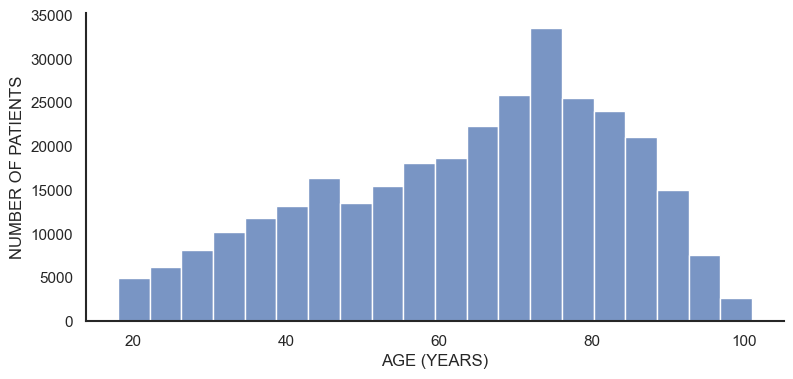

In [179]:
plt.figure(figsize=[9,4])
img = sns.histplot(data=df, x='age', bins=20)
img.set_ylabel('NUMBER OF PATIENTS')
img.set_xlabel('AGE (YEARS)')
fig = img.get_figure()
fig.savefig('Age histogram.tiff', dpi=600, bbox_inches='tight')

In [180]:
df.groupby('outcome')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
outcome,,,,,,,,
death,98626.0,71.289660,16.063895,18.0,62.0,74.0,83.0,101.0
survival,216102.0,60.574891,19.604385,18.0,45.0,63.0,76.0,101.0


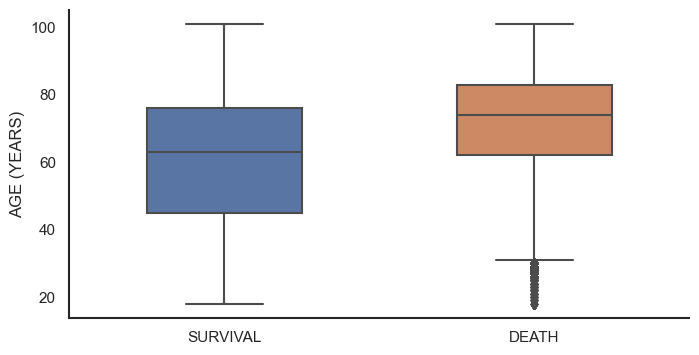

In [181]:
img = sns.boxplot(data=df, x='outcome', y='age', width=0.5)
img.set_ylabel('AGE (YEARS)')
img.set_xlabel(None)
img.set_xticklabels(['SURVIVAL', 'DEATH'])
fig = img.get_figure()
fig.savefig('Age boxplot.tiff', dpi=600, bbox_inches='tight')

### Sex

In [182]:
# argument dropna from groupby is not working in this version of pandas
sex = df.groupby('sex')['outcome'].value_counts().unstack()
sex.loc['missing_sex'] = df[df['sex'].isna()]['outcome'].value_counts()
sex

outcome,death,survival
sex,,
female,44698,104866
male,53921,111222
missing_sex,7,14


### Race

In [183]:
race = df.groupby('race')['outcome'].value_counts().unstack()
race.loc['missing_race'] = df[df['race'].isna()]['outcome'].value_counts()
race

outcome,death,survival
race,,
asian,955,2097
black,4523,7909
indigenous,156,349
mixed,31288,66297
white,47805,102452
missing_race,13899,36998


### Education

In [184]:
ed = df.groupby('education')['outcome'].value_counts().unstack()
ed.loc['missing_education'] = df[df['education'].isna()]['outcome'].value_counts()
ed

outcome,death,survival
education,,
illiterate,4294,5144
5_grade,13525,19973
9_grade,7195,13126
12_grade,8548,22466
higher_ed,3507,10517
missing_education,61557,144876


In [185]:
dem_table = pd.concat([sex, race, ed])
dem_table.to_excel('Demographics_table.xlsx')
dem_table

outcome,death,survival
female,44698,104866
male,53921,111222
missing_sex,7,14
asian,955,2097
black,4523,7909
indigenous,156,349
mixed,31288,66297
white,47805,102452
missing_race,13899,36998
illiterate,4294,5144


## 3.2 Vaccination

### Vaccination status

In [186]:
vac_status = df.groupby('vaccination_status')['outcome'].value_counts().unstack()
vac_status.loc['missing_vaccination'] = df[df['vaccination_status'].isna()]['outcome'].value_counts()
vac_status.to_excel('vaccination_status.xlsx')
vac_status

outcome,death,survival
vaccination_status,,
vaccinated,64692,134909
unvaccinated,23775,56284
missing_vaccination,10159,24909


### Time between hospitalization and vaccination

In [187]:
df['timedelta_hosp_vac'].describe()

count    314728.000000
mean        117.482032
std         129.382165
min           0.000000
25%           0.000000
50%          86.000000
75%         201.000000
max         691.000000
Name: timedelta_hosp_vac, dtype: float64

In [188]:
days_table = df.groupby('outcome')['timedelta_hosp_vac'].describe().T
days_table.to_excel('Days_hosp_last_vac_outcome.xlsx')
days_table

outcome,death,survival
count,98626.000000,216102.000000
mean,124.555736,114.253690
std,128.803435,129.517397
min,0.000000,0.000000
25%,0.000000,0.000000
50%,104.000000,76.000000
75%,210.000000,198.000000
max,678.000000,691.000000


In [189]:
def get_vac_dose_label(first, second, booster): 
    if booster == 1: 
        return 'BOOSTER DOSE'
    elif second == 1: 
        return 'SECOND DOSE'
    elif first == 1: 
        return 'FIRST DOSE'
    else:
        return 'NO DATE'

# Testing get_vac_dose_label: 
print(get_vac_dose_label(1,1,1) == 'BOOSTER DOSE')
print(get_vac_dose_label(1,1,0) == 'SECOND DOSE')
print(get_vac_dose_label(1,0,0) == 'FIRST DOSE')
print(get_vac_dose_label(0,0,0) == 'NO DATE')
    
df['vac_dose_label'] = np.vectorize(get_vac_dose_label)(df['first_dose_date'],
                                                        df['second_dose_date'], 
                                                        df['booster_date'])
vac_cat = ['BOOSTER DOSE', 'SECOND DOSE', 'FIRST DOSE', 'NO DATE']
df['vac_dose_label'] = pd.Categorical(df['vac_dose_label'], categories=vac_cat) 
df['vac_dose_label'].value_counts().sort_index()

True
True
True
True


vac_dose_label
BOOSTER DOSE     58234
SECOND DOSE     110722
FIRST DOSE       30758
NO DATE         115014
Name: count, dtype: int64

In [190]:
df[df['vac_dose_label'] == 'BOOSTER DOSE'][vaccination].head()

,vaccination_status,first_dose_date,second_dose_date,booster_date,timedelta_hosp_vac
1019,vaccinated,1,1,1,163.0
1106,vaccinated,1,1,1,97.0
1112,vaccinated,1,1,1,10.0
2107,vaccinated,1,1,1,13.0
2163,vaccinated,1,1,1,49.0


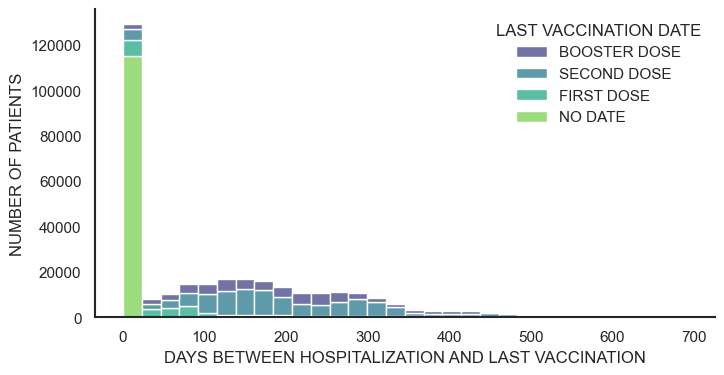

In [191]:
# Histogram with hue separating patients with the first date of vaccination filled out
img = sns.histplot(x='timedelta_hosp_vac', data=df,  hue='vac_dose_label',
                   multiple='stack', bins=30, palette='viridis')
img.set_ylabel('NUMBER OF PATIENTS')
img.set_xlabel('DAYS BETWEEN HOSPITALIZATION AND LAST VACCINATION')
leg = img.get_legend()
leg.set_title('LAST VACCINATION DATE')
leg.set_frame_on(False)
fig = img.get_figure()
fig.savefig('Days_hosp_last_vac.tiff', dpi=600, bbox_inches='tight')

In [192]:
def simplify_pvalue(pvalue):
    if pvalue >= 0.01:
        return str(pvalue)
    else:
        return '<0.01'
    
# Test simplify_pvalue
print(simplify_pvalue(0.01) == '0.01')
print(simplify_pvalue(0.2) == '0.2')
print(simplify_pvalue(0.001) == '<0.01')

True
True
True


### Presence of dates of vaccination

In [193]:
vac_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
vac_table_cont = pd.DataFrame(columns=['death', 'survival'])

for vac in vaccination[1:-1]:
    cont_table = df.groupby(vac)['outcome'].value_counts().unstack()[['death', 'survival']]
    cont_table = cont_table.reindex([1,0])
    cont_table.rename({1:'present', 0: 'absent'}, axis=0, inplace=True)
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = simplify_pvalue(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)
    vac_table.loc[vac, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    vac_table.loc[vac, 'pvalue'] = fisher
    cont_table.reset_index(inplace=True)
    cont_table.rename({vac:'category'}, axis=1, inplace=True)
    cont_table.index = [vac]*2
    vac_table_cont = pd.concat([vac_table_cont, cont_table])

vac_table = vac_table_cont.join(vac_table)
vac_table = vac_table.reindex(['category', 'death', 'survival', 
                               'odds_ratio', 'pvalue'], axis=1).copy()
vac_table.to_excel('vaccination_table.xlsx')
vac_table

,category,death,survival,odds_ratio,pvalue
booster_date,present,16723,41511,0.86 (0.84-0.88),<0.01
booster_date,absent,81903,174591,0.86 (0.84-0.88),<0.01
first_dose_date,present,64752,134962,1.15 (1.13-1.17),<0.01
first_dose_date,absent,33874,81140,1.15 (1.13-1.17),<0.01
second_dose_date,present,56736,112220,1.25 (1.23-1.27),<0.01
second_dose_date,absent,41890,103882,1.25 (1.23-1.27),<0.01


## 3.3 Comorbidities

In [194]:
comorb_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
comorb_table_cont = pd.DataFrame(columns=['death', 'survival'])

for comorb in comorbidities: 
    cont_table = df.groupby(comorb)['outcome'].value_counts().unstack()[['death', 'survival']]
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = simplify_pvalue(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)
    comorb_table.loc[comorb, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    comorb_table.loc[comorb, 'pvalue'] = fisher
    cont_table.reset_index(inplace=True)
    cont_table.rename({comorb:'category'}, axis=1, inplace=True)
    cont_table.index = [comorb]*2
    comorb_table_cont = pd.concat([comorb_table_cont, cont_table])

comorb_table = comorb_table_cont.join(comorb_table)
comorb_table = comorb_table.reindex(['category', 'death', 
                                     'survival', 'odds_ratio', 'pvalue'], 
                                    axis=1).copy()
comorb_table.to_excel('Comorbidity_table.xlsx')
comorb_table

,category,death,survival,odds_ratio,pvalue
asthma,asthma,1948,5670,0.62 (0.59-0.65),<0.01
asthma,no_asthma,42455,76391,0.62 (0.59-0.65),<0.01
blood_disease,blood_disease,1192,1727,1.27 (1.18-1.37),<0.01
blood_disease,no_blood_disease,43126,79340,1.27 (1.18-1.37),<0.01
diabetes,diabetes,28211,45570,1.19 (1.17-1.22),<0.01
diabetes,no_diabetes,27450,52824,1.19 (1.17-1.22),<0.01
heart_disease,heart_disease,42271,67537,1.29 (1.27-1.32),<0.01
heart_disease,no_heart_disease,18824,38914,1.29 (1.27-1.32),<0.01
immunodeficiency,immunodeficiency,5107,6401,1.5 (1.44-1.56),<0.01
immunodeficiency,no_immunodeficiency,40444,75892,1.5 (1.44-1.56),<0.01


In [195]:
# Missing values 
missing_comorb = pd.DataFrame(columns=['death', 'survival'])

for comorb in comorbidities: 
    missing_comorb.loc['missing_' + comorb] = df[df[comorb].isna()]['outcome'].value_counts()
    
missing_comorb.to_excel('missing_comorbidities.xlsx')
missing_comorb

,death,survival
missing_diabetes,42965,117708
missing_obesity,52575,131963
missing_lung_disease,52134,132688
missing_liver_disease,54338,135442
missing_heart_disease,37531,109651
missing_kidney_disease,52088,133190
missing_asthma,54223,134041
missing_blood_disease,54308,135035
missing_immunodeficiency,53075,133809
missing_pregnancy,54099,135410


## 3.4 Signs and Symptoms

In [196]:
symp_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
symp_table_cont = pd.DataFrame(columns=['death', 'survival'])

for symp in signs_symptoms: 
    cont_table = df.groupby(symp)['outcome'].value_counts().unstack()[['death', 'survival']]
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = (lambda x: str(x) if x >= 0.01 else '<0.01')(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)
    symp_table.loc[symp, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    symp_table.loc[symp, 'pvalue'] = fisher
    cont_table.reset_index(inplace=True)
    cont_table.rename({symp:'category'}, axis=1, inplace=True)
    cont_table.index = [symp]*2
    symp_table_cont = pd.concat([symp_table_cont, cont_table])

symp_table = symp_table_cont.join(symp_table)
symp_table = symp_table.reindex(['category', 'death', 'survival', 
                                 'odds_ratio', 'pvalue'], axis=1).copy()
symp_table.to_excel('Symptoms_table.xlsx')
symp_table

,category,death,survival,odds_ratio,pvalue
abdominal_pain,abdominal_pain,5393,14078,0.88 (0.85-0.91),<0.01
abdominal_pain,no_abdominal_pain,55346,126646,0.88 (0.85-0.91),<0.01
cough,cough,58177,147606,0.7 (0.68-0.71),<0.01
cough,no_cough,21937,38735,0.7 (0.68-0.71),<0.01
diarrhea,diarrhea,8987,21927,0.94 (0.91-0.96),<0.01
diarrhea,no_diarrhea,53529,122235,0.94 (0.91-0.96),<0.01
dyspnea,dyspnea,72398,129915,2.2 (2.15-2.25),<0.01
dyspnea,no_dyspnea,12512,49414,2.2 (2.15-2.25),<0.01
fatigue,fatigue,23135,52569,1.02 (1.0-1.04),0.05
fatigue,no_fatigue,42093,97531,1.02 (1.0-1.04),0.05


In [197]:
# Missing values 
missing_symp = pd.DataFrame(columns=['death', 'survival'])

for symp in signs_symptoms: 
    missing_symp.loc['missing_' + symp] = df[df[symp].isna()]['outcome'].value_counts()
    
missing_symp.to_excel('missing_signs_symptoms.xlsx')
missing_symp

,death,survival
missing_fever,23625,43426
missing_cough,18512,29761
missing_sore_throat,35547,66662
missing_dyspnea,13716,36773
missing_resp_discomfort,21152,51417
missing_oxygen_saturation,15587,42987
missing_diarrhea,36110,71940
missing_vomiting,36981,73374
missing_abdominal_pain,37887,75378
missing_fatigue,33398,66002


# 4. Machine Learning Models

In [198]:
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
from boruta import BorutaPy
import graphviz
import shap

## 4.1 Preprocessing of training and test sets

### Features

In [199]:
# Features
X = pd.DataFrame()

### continous variables ###
X = pd.concat([X, df[['age'] + [vaccination[-1]]]], axis = 1)

### categorical variables ###
# sex 
sex = pd.get_dummies(df['sex'], dtype=int,
                     dummy_na=True, drop_first=True)
sex.columns = sex.columns.fillna('missing_sex')

# race 
race = pd.get_dummies(df['race'], dtype=int,
                      dummy_na=True, drop_first=True)
race.columns = race.columns.fillna('missing_race')

# education
education = pd.get_dummies(df['education'], dtype=int,
                           dummy_na=True, drop_first=True)
education.columns = education.columns.fillna('missing_education')

# vaccination 
vaccination_status = pd.get_dummies(df['vaccination_status'], dtype=int,
                                    dummy_na=True, drop_first=True)
vaccination_status.columns = vaccination_status.columns.fillna('missing_vaccination')

# vaccination dates
vaccination_dates = df[vaccination[1:-1]]

X = pd.concat([X, sex, race, education, vaccination_status, vaccination_dates], axis=1)

# comorbidities and symptoms
comorb_symp = comorbidities + signs_symptoms

for column in comorb_symp: 
    dummies = pd.get_dummies(df[column], dtype=int, dummy_na=True)
    dummies.drop(columns=f'no_{column}', inplace=True)
    dummies.columns = dummies.columns.fillna(f'missing_{column}')
    X = pd.concat([X, dummies], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314728 entries, 0 to 314727
Data columns (total 65 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        314728 non-null  int64  
 1   timedelta_hosp_vac         314728 non-null  float64
 2   male                       314728 non-null  int64  
 3   missing_sex                314728 non-null  int64  
 4   black                      314728 non-null  int64  
 5   indigenous                 314728 non-null  int64  
 6   mixed                      314728 non-null  int64  
 7   white                      314728 non-null  int64  
 8   missing_race               314728 non-null  int64  
 9   5_grade                    314728 non-null  int64  
 10  9_grade                    314728 non-null  int64  
 11  12_grade                   314728 non-null  int64  
 12  higher_ed                  314728 non-null  int64  
 13  missing_education          31

### Target variable

In [200]:
# Target variable
y = pd.get_dummies(df['outcome'], dtype=int).drop(columns='survival')['death']
y

0         0
1         0
2         0
3         1
4         1
         ..
314723    0
314724    0
314725    0
314726    1
314727    0
Name: death, Length: 314728, dtype: int64

### Train-test split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True)
print(X_train.shape)
print(X_test.shape)

(220309, 65)
(94419, 65)


### Z score transformation

In [202]:
continuous_col = ['age', 'timedelta_hosp_vac'] # continuous variables

scaler = ColumnTransformer([('scaler', StandardScaler(), continuous_col)], 
                           remainder='passthrough') # this will keep the other columns intact
  
scaler.fit(X_train)
print(scaler)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['age', 'timedelta_hosp_vac'])])


In [203]:
X_train = scaler.transform(X_train) # returns an array
X_train = pd.DataFrame(X_train, columns=X.columns) # converts the data back to a dataframe
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220309 entries, 0 to 220308
Data columns (total 65 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        220309 non-null  float64
 1   timedelta_hosp_vac         220309 non-null  float64
 2   male                       220309 non-null  float64
 3   missing_sex                220309 non-null  float64
 4   black                      220309 non-null  float64
 5   indigenous                 220309 non-null  float64
 6   mixed                      220309 non-null  float64
 7   white                      220309 non-null  float64
 8   missing_race               220309 non-null  float64
 9   5_grade                    220309 non-null  float64
 10  9_grade                    220309 non-null  float64
 11  12_grade                   220309 non-null  float64
 12  higher_ed                  220309 non-null  float64
 13  missing_education          22

In [204]:
X_test = scaler.transform(X_test) # returns an array
X_test = pd.DataFrame(X_test, columns=X.columns) # converts the data back to a dataframe
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94419 entries, 0 to 94418
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        94419 non-null  float64
 1   timedelta_hosp_vac         94419 non-null  float64
 2   male                       94419 non-null  float64
 3   missing_sex                94419 non-null  float64
 4   black                      94419 non-null  float64
 5   indigenous                 94419 non-null  float64
 6   mixed                      94419 non-null  float64
 7   white                      94419 non-null  float64
 8   missing_race               94419 non-null  float64
 9   5_grade                    94419 non-null  float64
 10  9_grade                    94419 non-null  float64
 11  12_grade                   94419 non-null  float64
 12  higher_ed                  94419 non-null  float64
 13  missing_education          94419 non-null  flo

In [205]:
X_test['age'].describe()

count    94419.000000
mean        -0.000523
std          1.000827
min         -2.390413
25%         -0.725185
50%          0.159467
75%          0.783928
max          1.928772
Name: age, dtype: float64

In [206]:
X_test['timedelta_hosp_vac'].describe()

count    94419.000000
mean         0.002884
std          1.005172
min         -0.908570
25%         -0.908570
50%         -0.250580
75%          0.655124
max          4.440502
Name: timedelta_hosp_vac, dtype: float64

In [207]:
# Dataframes with the metrics from all the models:

# Default hyperparameters
df_models = pd.DataFrame()
df_models.index.name = 'Model'

# Optimized hyperparameters
df_models_opt = pd.DataFrame()
df_models.index.name = 'Model'

## 4.2 Model training and optimization

### Decision tree

#### Default hyperparameters

In [208]:
model_name = 'Decision Tree'
print(model_name, '- Default Hyperparameters') 

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
prob_pos = dt_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Decision Tree - Default Hyperparameters
Accuracy: 0.6295
Precision: 0.4103
Recall: 0.4245
F1 score: 0.4173
AUC: 0.5746


#### Optimized hyperparameters

In [209]:
model_name = 'Decision Tree'
print(model_name, '- Optimized Hyperparameters')

dt_clf = DecisionTreeClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_dt = RandomizedSearchCV(
    dt_clf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5,
    random_state=42,
    n_jobs=-1
)
    
# Fitting randomized search to training data
cv_dt.fit(X_train, y_train)
print(cv_dt.best_params_)

# Training the best tree
best_dt_clf = cv_dt.best_estimator_
best_dt_clf.fit(X_train, y_train)

# Model prediction
y_pred = best_dt_clf.predict(X_test)
prob_pos = best_dt_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models_opt.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models_opt.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Decision Tree - Optimized Hyperparameters
{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 9, 'criterion': 'gini'}
Accuracy: 0.7080
Precision: 0.5590
Recall: 0.3114
F1 score: 0.4000
AUC: 0.7156


#### Exporting the tree with high resolution

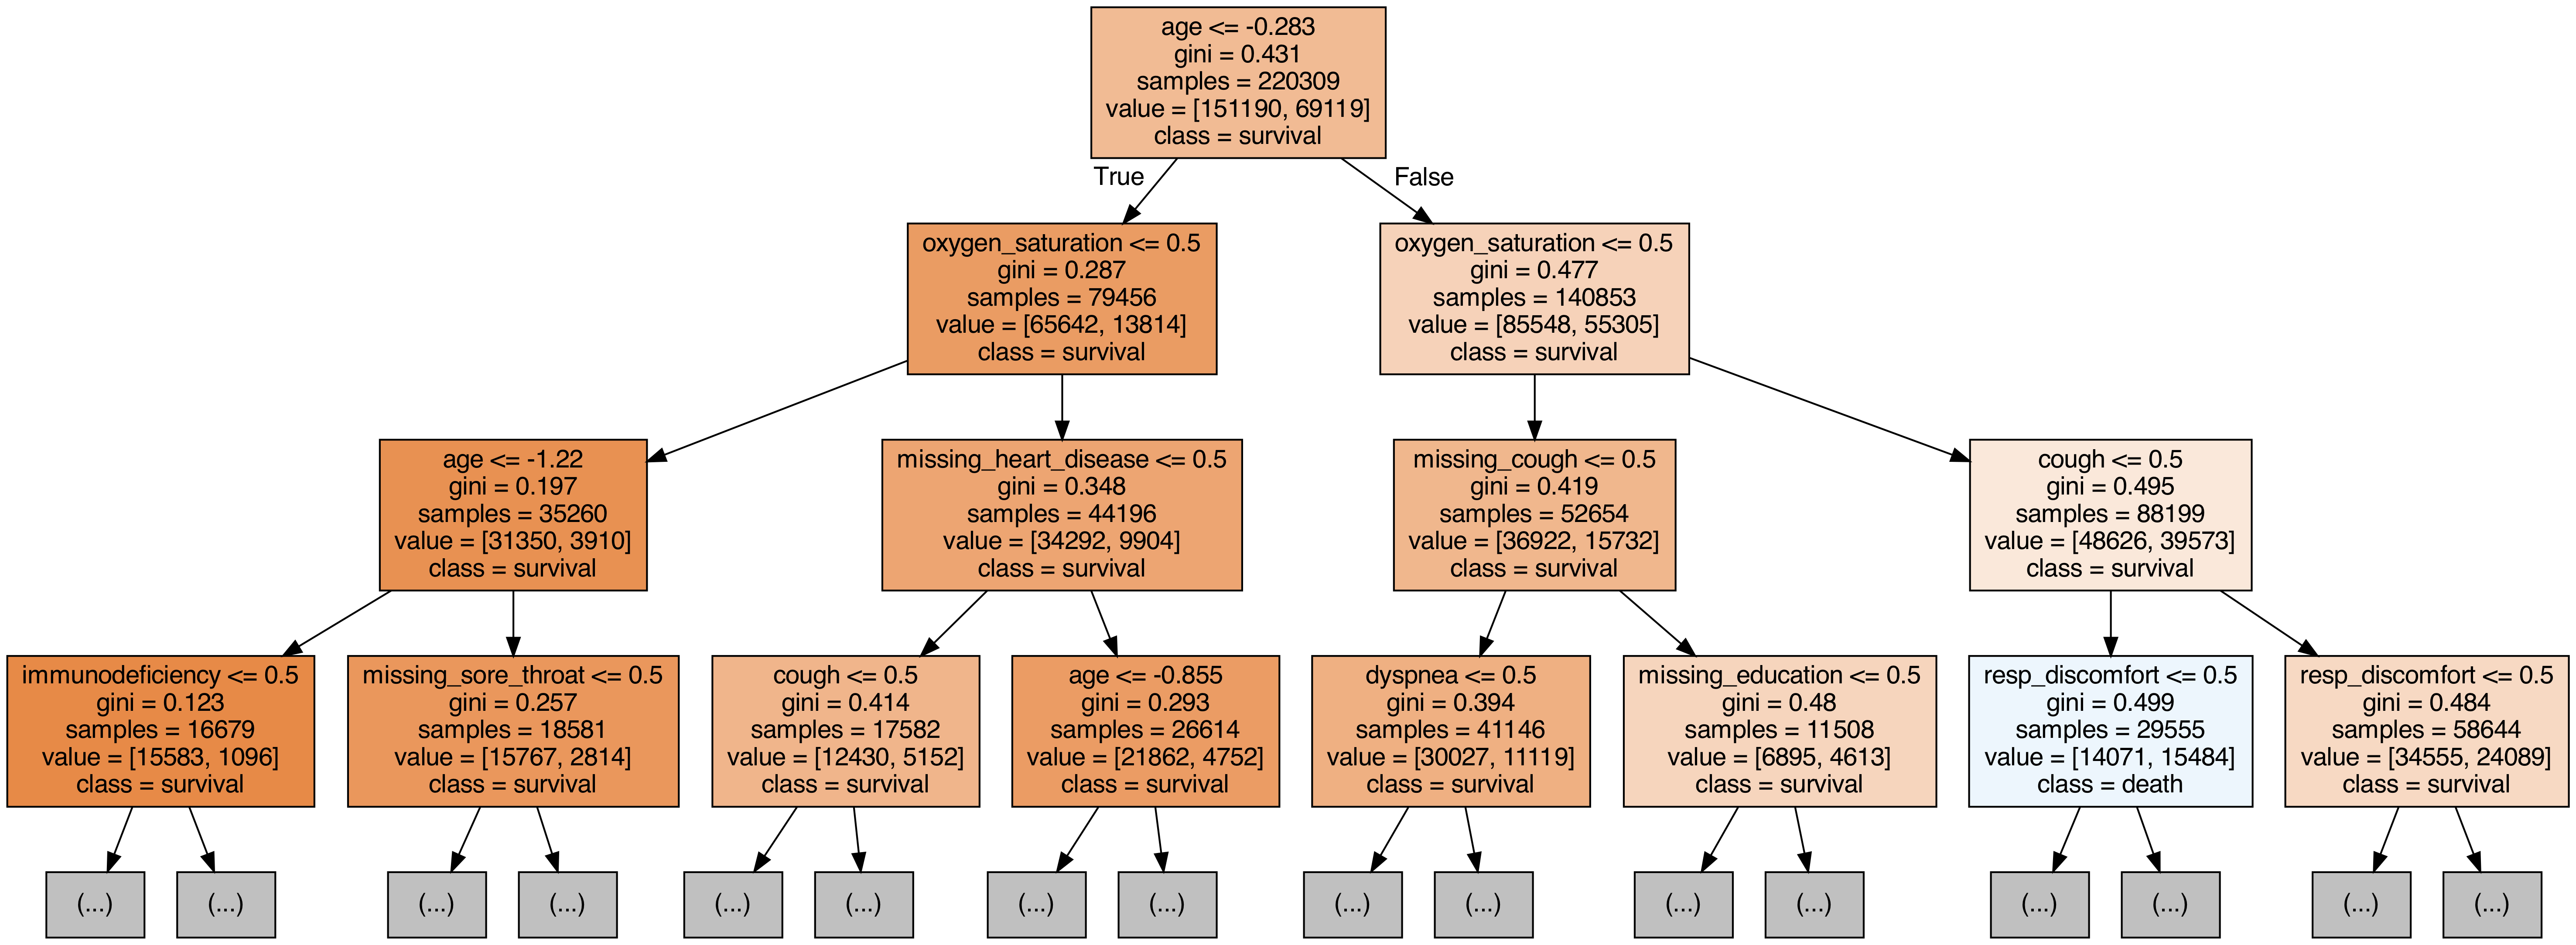

In [210]:
# Creating dot data file
dot_data = export_graphviz(best_dt_clf, out_file='tree.gv', 
                           feature_names=X.columns,  
                           class_names={1:'death', 0:'survival'},
                           max_depth=3,
                           filled=True)

# Creating figure from dot data
import os
os.system('dot -Tpng -Gdpi=300 tree.gv -o tree.png')

# Displaying the image 
from IPython.display import Image
Image(filename='tree.png') 

__________

### Random Forest

#### Default hyperparameters

In [211]:
model_name = 'Random Forest'
print(model_name, '- Default Hyperparameters')

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Model prediction
y_pred = rf_clf.predict(X_test)
prob_pos = rf_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Random Forest - Default Hyperparameters
Accuracy: 0.6986
Precision: 0.5279
Recall: 0.3362
F1 score: 0.4108
AUC: 0.7012


#### Optimized hyperparameters

In [212]:
model_name = 'Random Forest'
print(model_name, '- Optimized Hyperparameters')

rf_clf = RandomForestClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_rf = RandomizedSearchCV(
    rf_clf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_rf.fit(X_train, y_train)
print(cv_rf.best_params_)

# Model predictions
y_pred = cv_rf.predict(X_test)
prob_pos = cv_rf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models_opt.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models_opt.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Random Forest - Optimized Hyperparameters
{'oob_score': False, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Accuracy: 0.7155
Precision: 0.5831
Recall: 0.3148
F1 score: 0.4088
AUC: 0.7309


________

### XGBoost

#### Default hyperparameters

In [213]:
model_name = 'XGBoost'
print(model_name, '- Default Hyperparameters')

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# Model predictions
y_pred = xgb_clf.predict(X_test)
prob_pos = xgb_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

XGBoost - Default Hyperparameters
Accuracy: 0.7202
Precision: 0.5887
Recall: 0.3475
F1 score: 0.4370
AUC: 0.7389


#### Optimized hyperparameters

In [214]:
model_name = 'XGBoost'
print(model_name, '- Optimized Hyperparameters')

xgb_clf = xgb.XGBClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'objective': ['binary:logistic'],
    'eval_metric': ['auc', 'accuracy'],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fitting the randomized search to some data X and labels y
cv_xgb.fit(X_train, y_train)
print(cv_xgb.best_params_)

# Mode predictions 
y_pred = cv_xgb.predict(X_test)
prob_pos = cv_xgb.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models_opt.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models_opt.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

XGBoost - Optimized Hyperparameters
{'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'eval_metric': 'auc', 'colsample_bytree': 0.8}
Accuracy: 0.7213
Precision: 0.5942
Recall: 0.3415
F1 score: 0.4338
AUC: 0.7424


______

### CatBoost

#### Default hyperparameters

In [215]:
model_name = 'CatBoost'
print(model_name, '- Default Hyperparameters')

cat_clf = CatBoostClassifier(random_state=42, silent=True)
cat_clf.fit(X_train, y_train)

# Model predictions
y_pred = cat_clf.predict(X_test)
prob_pos = cat_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

CatBoost - Default Hyperparameters
Accuracy: 0.7213
Precision: 0.5933
Recall: 0.3445
F1 score: 0.4359
AUC: 0.7424


#### Optimized hyperparameters

In [216]:
model_name = 'CatBoost'
print(model_name, '- Optimized Hyperparameters')

cat_clf = CatBoostClassifier(random_state=42, silent=True)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.03, 0.1, 0.15, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [100, 200, 300, 400, 500],
    'random_strength': [0.01, 0.1, 1, 10, 100],
    'border_count': [32, 64, 96, 128],
    'loss_function': ['Logloss', 'CrossEntropy'],
    'eval_metric': ['AUC', 'Accuracy'],
    'boosting_type': ['Plain', 'Ordered', 'PlainWithEarlyStopping', 'OrderedWithEarlyStopping'],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_cat = RandomizedSearchCV(
    cat_clf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_cat.fit(X_train, y_train)
print(cv_cat.best_params_)

# Model predictions
y_pred = cv_cat.predict(X_test)
prob_pos = cv_cat.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models_opt.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models_opt.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

CatBoost - Optimized Hyperparameters
{'random_strength': 0.1, 'loss_function': 'CrossEntropy', 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 500, 'eval_metric': 'AUC', 'depth': 10, 'border_count': 128, 'boosting_type': 'Plain'}
Accuracy: 0.7214
Precision: 0.5965
Recall: 0.3353
F1 score: 0.4293
AUC: 0.7431


_____

### Logistic Regression

#### Default hyperparameters

In [217]:
model_name = 'Logistic Regression'
print(model_name, 'Default Hyperparameters')

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Model predictions
y_pred = lr.predict(X_test)
prob_pos = lr.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Logistic Regression Default Hyperparameters
Accuracy: 0.7166
Precision: 0.5860
Recall: 0.3173
F1 score: 0.4117
AUC: 0.7324


#### Optimized hyperparameters

In [218]:
model_name = 'Logistic Regression'
print(model_name, '- Optimized Hyperparameters')

lr = LogisticRegression(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': uniform(0, 10),
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000, 10000]
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_lr = RandomizedSearchCV(
    lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_lr.fit(X_train, y_train)
print(cv_lr.best_params_)

# Model predictions 
y_pred = cv_lr.predict(X_test)
prob_pos = cv_lr.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models_opt.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models_opt.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Logistic Regression - Optimized Hyperparameters
{'C': 4.592488919658671, 'fit_intercept': True, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7166
Precision: 0.5862
Recall: 0.3171
F1 score: 0.4116
AUC: 0.7324


____

### Multilinear Perceptron

#### Default hyperparameters

In [219]:
model_name = 'Multilinear Perceptron'
print(model_name, '- Default Hyperparameters')

mlp_clf = MLPClassifier(random_state=42)
mlp_clf.fit(X_train, y_train)

# Model predictions
y_pred = mlp_clf.predict(X_test)
prob_pos = mlp_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Multilinear Perceptron - Default Hyperparameters
Accuracy: 0.7132
Precision: 0.5597
Recall: 0.3847
F1 score: 0.4560
AUC: 0.7297


#### Optimized hyperparameters

In [220]:
model_name = 'Multilinear Perceptron'
print(model_name, '- Optimized Hyperparameters')

mlp_clf = MLPClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'hidden_layer_sizes': randint(1, 100),
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [1000]
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_mlp = RandomizedSearchCV(
    mlp_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_mlp.fit(X_train, y_train)
print(cv_mlp.best_params_)

# Model predictions
y_pred = cv_mlp.predict(X_test)
prob_pos = cv_mlp.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models_opt.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models_opt.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models_opt.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Multilinear Perceptron - Optimized Hyperparameters
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 92, 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'}
Accuracy: 0.7205
Precision: 0.5937
Recall: 0.3343
F1 score: 0.4278
AUC: 0.7394


____

### Model comparison

In [221]:
all_models = pd.concat([df_models, df_models_opt], axis=1, 
                          keys=['Default', 'Optimized'])
all_models.T.to_excel('Machine_learning_metrics.xlsx')
all_models.T

Decision Tree  Random Forest  XGBoost  CatBoost   
Default   Accuracy          0.6295         0.6986   0.7202    0.7213  \
          Precision         0.4103         0.5279   0.5887    0.5933   
          Recall            0.4245         0.3362   0.3475    0.3445   
          F1 score          0.4173         0.4108   0.4370    0.4359   
          AUC               0.5746         0.7012   0.7389    0.7424   
Optimized Accuracy          0.7080         0.7155   0.7213    0.7214   
          Precision         0.5590         0.5831   0.5942    0.5965   
          Recall            0.3114         0.3148   0.3415    0.3353   
          F1 score          0.4000         0.4088   0.4338    0.4293   
          AUC               0.7156         0.7309   0.7424    0.7431   

                     Logistic Regression  Multilinear Perceptron  
Default   Accuracy                0.7166                  0.7132  
          Precision               0.5860                  0.5597  
          Recall                  0.3173                  0.3847  
          F1 score                0.4117                  0.4560  
          AUC                     0.7324                  0.7297  
Optimized Accuracy                0.7166                  0.7205  
          Precision               0.5862                  0.5937  
          Recall                  0.3171                  0.3343  
          F1 score                0.4116                  0.4278  
          AUC                     0.7324                  0.7394

## 4.3 Using Boruta for feature selection 

In [222]:
# Using Random Forest as estimator
rf = RandomForestClassifier(random_state=42, 
                            n_jobs = -1, 
                            max_depth = 5) 

boruta = BorutaPy(estimator=rf, 
                  n_estimators='auto',
                  max_iter=100)
boruta.fit(np.array(X_train), np.array(y_train)) 

# Determining the best features
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print()
print('features in the blue area:', blue_area)
print()

n_features = X_train.shape[1]
n_features_boruta = X_train[green_area].shape[1]
print(f'Boruta has eliminated {n_features - n_features_boruta} features:')

eliminated_features = []
for column in X.columns: 
    if column not in green_area:
        eliminated_features.append(column)
print(eliminated_features)

features in the green area: ['age', 'timedelta_hosp_vac', 'male', 'missing_race', '5_grade', '12_grade', 'higher_ed', 'missing_education', 'first_dose_date', 'second_dose_date', 'booster_date', 'diabetes', 'missing_diabetes', 'obesity', 'missing_obesity', 'lung_disease', 'missing_lung_disease', 'liver_disease', 'missing_liver_disease', 'heart_disease', 'missing_heart_disease', 'kidney_disease', 'missing_kidney_disease', 'asthma', 'missing_asthma', 'missing_blood_disease', 'immunodeficiency', 'missing_immunodeficiency', 'pregnancy', 'missing_pregnancy', 'neuro_disease', 'missing_neuro_disease', 'fever', 'missing_fever', 'cough', 'missing_cough', 'sore_throat', 'missing_sore_throat', 'dyspnea', 'missing_dyspnea', 'resp_discomfort', 'missing_resp_discomfort', 'oxygen_saturation', 'missing_oxygen_saturation', 'missing_diarrhea', 'missing_vomiting', 'missing_abdominal_pain', 'fatigue', 'missing_fatigue', 'loss_smell', 'missing_loss_smell', 'loss_taste', 'missing_loss_taste']

features in th

In [223]:
df_boruta_metrics = pd.DataFrame()

cat_boruta = cv_cat.best_estimator_
cat_boruta.fit(X_train[green_area], y_train)

y_pred = cat_boruta.predict(X_test[green_area])
prob_pos = cat_boruta.predict_proba(X_test[green_area])[:,1]

model_name = 'Optimized CatBoost Boruta'
print(model_name)

accuracy = accuracy_score(y_test, y_pred)
df_boruta_metrics.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_boruta_metrics.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_boruta_metrics.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_boruta_metrics.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_boruta_metrics.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Optimized CatBoost Boruta
Accuracy: 0.7202
Precision: 0.5936
Recall: 0.3323
F1 score: 0.4261
AUC: 0.7415


In [224]:
df_boruta_metrics.loc['Optimized CatBoost'] = df_models_opt.loc['CatBoost']
df_boruta_metrics.T.to_excel('catboost_boruta.xlsx')
df_boruta_metrics.T

,Optimized CatBoost Boruta,Optimized CatBoost
Accuracy,0.7202,0.7214
Precision,0.5936,0.5965
Recall,0.3323,0.3353
F1 score,0.4261,0.4293
AUC,0.7415,0.7431


## 4.4 Density Plot

In [225]:
# Best model 
best_cat_clf = cv_cat.best_estimator_
best_cat_clf.fit(X_train, y_train)
y_pred = best_cat_clf.predict(X_test)
prob_pos = best_cat_clf.predict_proba(X_test)[:,1]
accuracy_score(y_test, y_pred)

0.7214014128512269

In [226]:
density = pd.concat([pd.Series(prob_pos, name='probability'), 
                     y_test.reset_index()['death']], axis=1)
density

,probability,death
0,0.121150,0
1,0.492000,1
2,0.456859,1
3,0.361558,0
4,0.515178,0
...,...,...
94414,0.306924,1
94415,0.107901,0
94416,0.281627,1
94417,0.383197,1


In [227]:
density.groupby('death')['probability'].describe()

,count,mean,std,min,25%,50%,75%,max
death,,,,,,,,
0,64912.0,0.263991,0.167288,0.001071,0.127781,0.238781,0.376467,0.932001
1,29507.0,0.420772,0.173906,0.005583,0.291691,0.419964,0.546647,0.947905


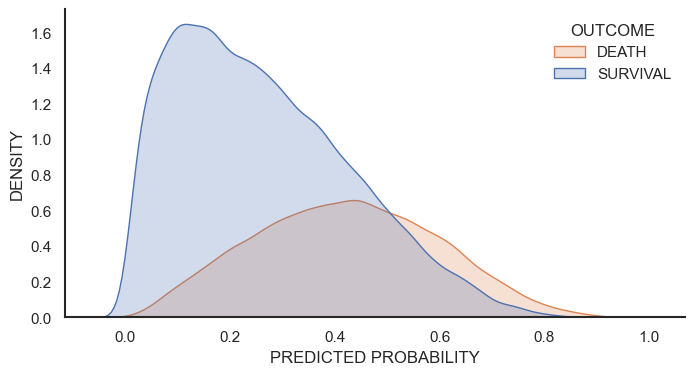

In [228]:
img = sns.kdeplot(x='probability', data=density, hue='death', fill=True,)
img.set_xlabel('PREDICTED PROBABILITY')
img.set_ylabel('DENSITY')
img.legend(labels=['DEATH', 'SURVIVAL'], title='OUTCOME')
leg = img.get_legend()
leg.set_frame_on(False)
fig = img.get_figure()
fig.savefig('probability_density.tiff', dpi=600, bbox_inches='tight')

## 4.5 SHAP Values

In [229]:
shap_values_test = shap.TreeExplainer(best_cat_clf).shap_values(X_test)
shap_values_test

array([[-5.64750139e-01,  6.60776283e-02,  8.62377119e-02, ...,
        -5.27178374e-02,  1.37391255e-02, -4.54729051e-02],
       [ 4.23360009e-01,  5.05694352e-04,  9.70545130e-02, ...,
        -2.63882197e-02, -1.99206834e-01, -2.90130899e-02],
       [ 4.03423915e-01,  1.19762698e-01, -9.10199806e-02, ...,
        -2.10688275e-02,  6.85002122e-03, -2.15235483e-02],
       ...,
       [ 7.72517805e-01,  2.27828681e-02,  8.64552266e-02, ...,
        -3.69734351e-02,  9.61034703e-03, -3.12685545e-02],
       [ 1.06772054e+00,  4.41746716e-02,  9.77055138e-02, ...,
        -5.18715705e-02,  1.06843420e-02, -4.08074873e-02],
       [ 1.10112777e+00, -1.04820793e-03,  1.19939048e-01, ...,
        -2.30513682e-02,  7.13208914e-03, -1.96024728e-02]])

In [230]:
def format_labels(label: str): 
    if label == 'resp_discomfort':
        label = 'respiratory_discomfort'
    elif label == 'oxygen_saturation':
        label = 'oxygen_saturation_<95%'
    elif label == 'timedelta_hosp_vac':
        label = 'time_hospital_-_last_vaccine'
    label = label.upper()
    words = label.split('_')
    return " ".join(words)

# Testing format_labels: 
print(format_labels('dyspnea') == 'DYSPNEA')
print(format_labels('resp_discomfort') == 'RESPIRATORY DISCOMFORT')
print(format_labels('oxygen_saturation') == 'OXYGEN SATURATION <95%')

figure_labels = [format_labels(x) for x in X.columns]

True
True
True


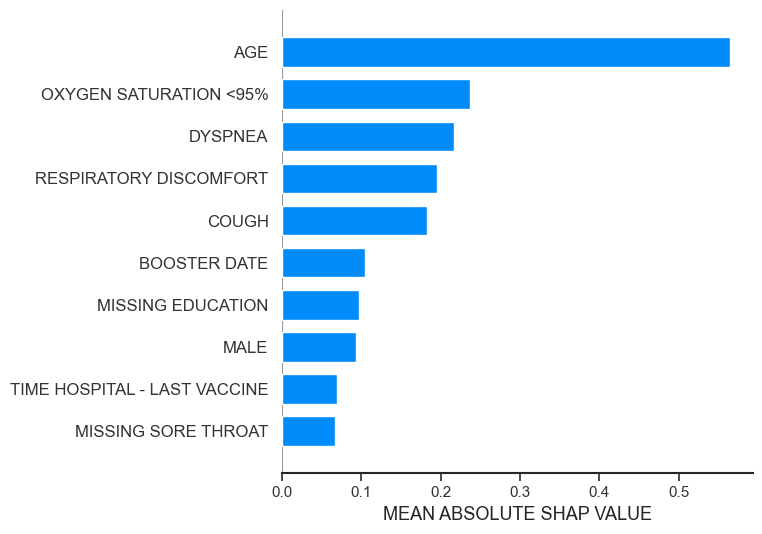

In [231]:
shap.summary_plot(shap_values_test, X_test, 
                  max_display=10, feature_names=figure_labels,
                  plot_type="bar", show=False)
plt.xlabel('MEAN ABSOLUTE SHAP VALUE')
plt.yticks(fontsize=12)
plt.savefig('shap_summary_bar.tiff', dpi=600)

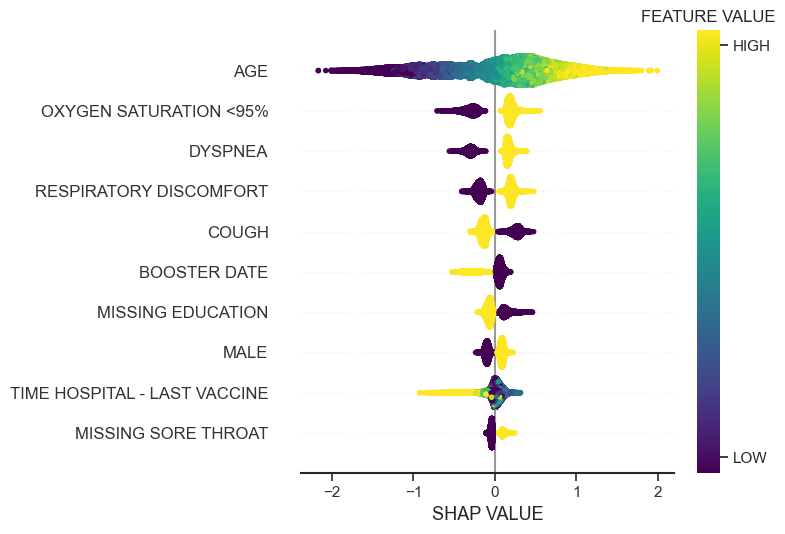

In [232]:
shap.summary_plot(shap_values_test, X_test, 
                  max_display=10, cmap='viridis', 
                  feature_names=figure_labels, show=False,
                  color_bar=False)
plt.xlabel('SHAP VALUE')
plt.yticks(fontsize=12)
colorbar = plt.colorbar()
colorbar.ax.set_title('FEATURE VALUE', fontsize=12)
colorbar.set_ticks(ticks=[-1.7, 1.3], labels=['LOW', 'HIGH'])
colorbar.outline.set_visible(False)
plt.tight_layout()
plt.savefig('shap_summary_values.tiff', dpi=600)